In [17]:
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from einops import rearrange
from pytorch_lightning import seed_everything
from torch.autocast_mode import autocast
from ldm.util import instantiate_from_config
from ldm.models.diffusion.plms import PLMSSampler

seed_everything(42)

config = OmegaConf.load("../configs/stable-diffusion/v1-inference.yaml")
pl_sd = torch.load("../models/ldm/stable-diffusion-v1/model.ckpt", map_location="cpu")
model = instantiate_from_config(config.model)
m, u = model.load_state_dict(pl_sd["state_dict"], strict=False)
model.cuda()
model.eval()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = PLMSSampler(model)

def run(prompt):
	with torch.no_grad():
		with autocast("cuda"):
			with model.ema_scope():
				uc = model.get_learned_conditioning([""])
				c = model.get_learned_conditioning([prompt])
				shape = [4, 512 // 8, 512 // 8]
				samples_ddim, _ = sampler.sample(S=50,
													conditioning=c,
													batch_size=1,
													shape=shape,
													verbose=False,
													unconditional_guidance_scale=7.5,
													unconditional_conditioning=uc,
													eta=0.0,
													x_T=None)

				x_samples_ddim = model.decode_first_stage(samples_ddim)
				x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
				x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

				# x_checked_image, has_nsfw_concept = check_safety(x_samples_ddim)
				x_checked_image = x_samples_ddim

				x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)

				for x_sample in x_checked_image_torch:
					x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
					img = Image.fromarray(x_sample.astype(np.uint8))
					display(img)


Global seed set to 42


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.18.layer_norm2.weight', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.mlp.fc2.weight', 'vision_model.encoder.layers.21.mlp.fc2.weight', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.2.layer_norm2.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.22.layer_norm1.weight', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_mo

## Breakfast

Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.17it/s]


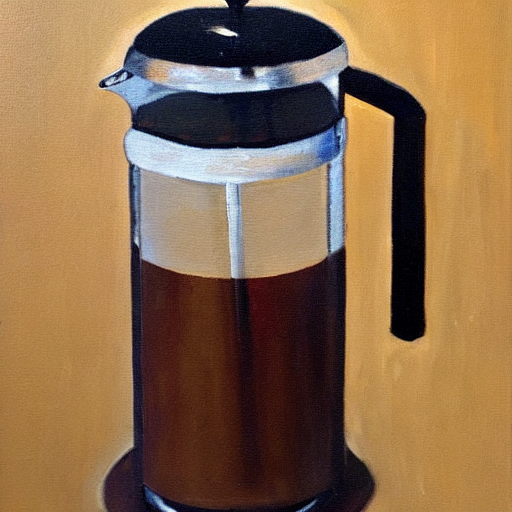

In [15]:
run("a french press full of coffee, oil painting")

Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


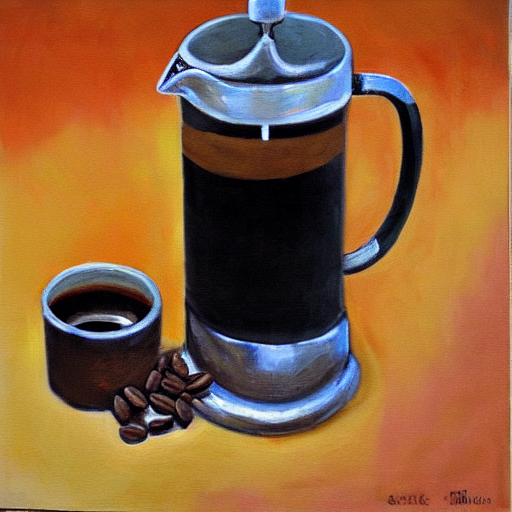

In [8]:
run("a french press full of coffee, oil painting")

Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.28it/s]


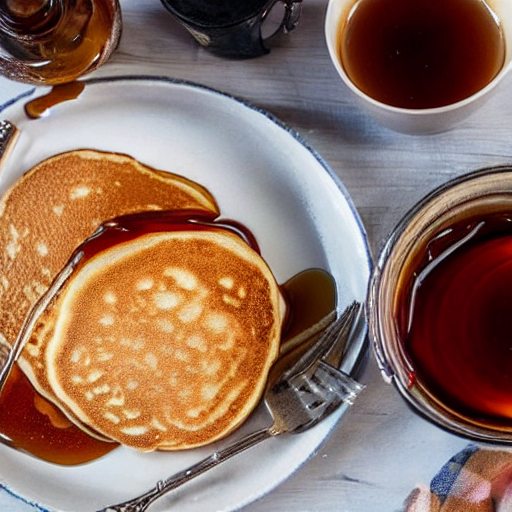

In [5]:
run("a photo of a pile of pancakes with syrup")

Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


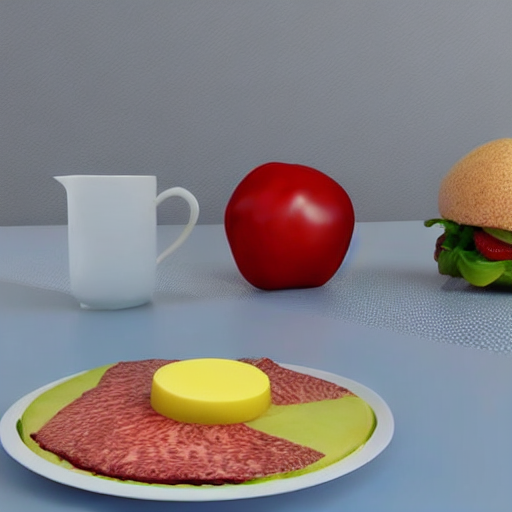

In [7]:
run("a detailed 3d render of a healthy breakfast")

## Work

In [ ]:
run("A notebook is sitting on a table next to a cup of tea. A detailed watercolor painting of the planet Jupiter is drawn in the notebook.")